In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the dataset


In [ ]:

data = pd.read_csv('/content/drive/MyDrive/440/IMDB Dataset.csv')

In [ ]:
data.head(8)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative


# We are assuming 'review' is the column with text and 'sentiment' is the target and doing encoding

In [ ]:
# 'review' is the column with text and 'sentiment' is the target
reviews = data['review']
labels = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)


#  Load GloVe embeddings

In [ ]:

def load_glove_embedd(path):
    embeddings_index = {}
    with open(path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [ ]:
gl_p = '/content/drive/MyDrive/440/glove.6B.100d.txt'
glove_embeddings = load_glove_embedd(gl_p)

# Here is task of Tokenize and pad sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index
padded = pad_sequences(sequences, maxlen=256)

Exception ignored in: <function AtomicFunction.__del__ at 0x7f31c2aff7f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

# Here we Prepare GloVe embedding matrix

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# New Section Here we split training and test

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42,stratify=labels)


In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()


# Shallow model with dense layer and also Training and Testing with different  batch sizes. Also calculting the loss opitamlly by uisng ADAM



In [ ]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

his2=model2.fit(X_train, y_train, epochs=20, batch_size=25, validation_data=(X_test, y_test))
train_loss2, train_accuracy2 = model2.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy2}')

loss2, accuracy2 = model2.evaluate(X_test, y_test)
print(f'Shallow Model Test Accuracy: {accuracy2}')
plot_history(his2)

# Uni LSTM model with dense layer and also Training and Testing with different batch sizes.Also calculting the loss opitamlly by uisng ADAM

Epoch 1/20
1539/1539 [==============================] - 85s 54ms/step - loss: 0.4064 - accuracy: 0.8076 - precision_12: 0.8010 - recall_12: 0.8184 - val_loss: 0.2754 - val_accuracy: 0.8914 - val_precision_12: 0.9173 - val_recall_12: 0.8604
Epoch 2/20
1539/1539 [==============================] - 38s 25ms/step - loss: 0.1760 - accuracy: 0.9361 - precision_12: 0.9378 - recall_12: 0.9341 - val_loss: 0.2576 - val_accuracy: 0.8949 - val_precision_12: 0.8880 - val_recall_12: 0.9038
Epoch 3/20
1539/1539 [==============================] - 31s 20ms/step - loss: 0.0697 - accuracy: 0.9786 - precision_12: 0.9790 - recall_12: 0.9783 - val_loss: 0.3458 - val_accuracy: 0.8828 - val_precision_12: 0.9129 - val_recall_12: 0.8464
Epoch 4/20
1539/1539 [==============================] - 30s 20ms/step - loss: 0.0271 - accuracy: 0.9934 - precision_12: 0.9936 - recall_12: 0.9930 - val_loss: 0.5289 - val_accuracy: 0.8618 - val_precision_12: 0.9203 - val_recall_12: 0.7922
Epoch 5/20
1539/1539 [==================

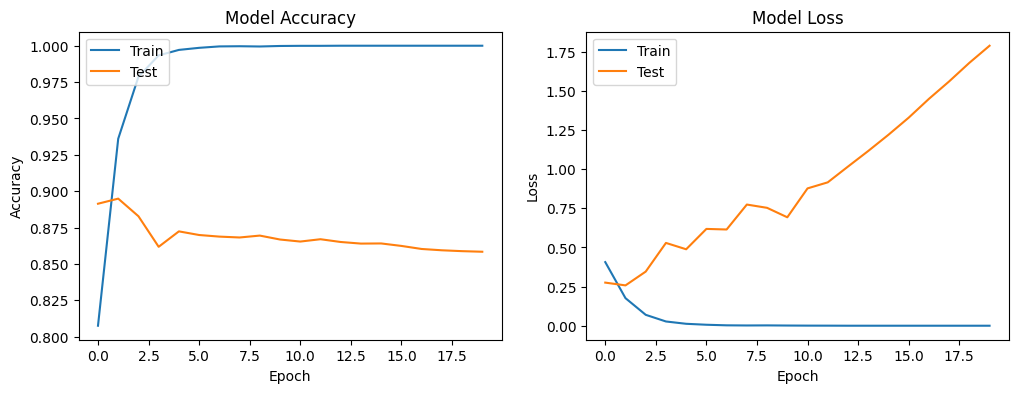

In [ ]:
# LSTM model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# Train the LSTM model
his=model.fit(X_train, y_train, epochs=20, batch_size=26, validation_data=(X_test, y_test))
train_loss, train_accuracy,p,r = model.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy}')

# Evaluate the LSTM model
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f'LSTM Model Test Accuracy: {accuracy}')
print(f'LSTM Model Test Precision: {precision}')
print(f'LSTM Model Test Recall: {recall}')
plot_history(his)

313/313 [==============================] - 2s 5ms/step


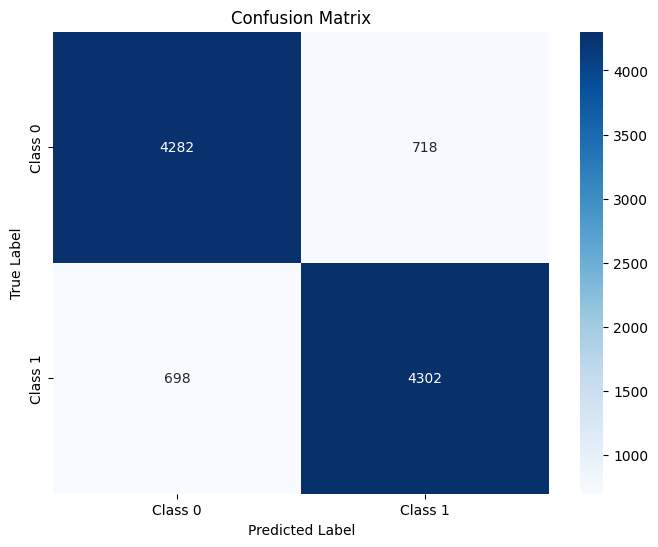

F1 Score: 0.858682634730539


In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Calculate the F1 score
f = f1_score(y_test, y_pred)
print(f"F1 Score: {f}")

# Bidirectional LSTM model with dense layer and also Training and Testing with different batch sizes.Also calculting the loss opitamlly by uisng ADAM

In [ ]:
# Bidirectional LSTM model
model1 = Sequential()
model1.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=False))
model1.add(Bidirectional(LSTM(10)))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

his1=model1.fit(X_train, y_train, epochs=20, batch_size=25, validation_data=(X_test, y_test))
train_loss1, train_accuracy1,p1,r1 = model1.evaluate(X_train, y_train)
print(f'Training Accuracy: {train_accuracy1}')

# Evaluate the Bidirectional LSTM model
loss1, accuracy1, precision1, recall1 = model1.evaluate(X_test, y_test)
print(f'Bidirectional LSTM Model Test Accuracy: {accuracy1}')
print(f'Bidirectional LSTM Model Test Precision: {precision1}')
print(f'Bidirectional LSTM Model Test Recall: {recall1}')
plot_history(his1)


Epoch 1/20
1600/1600 [==============================] - 44s 25ms/step - loss: 0.5363 - accuracy: 0.7228 - precision_13: 0.7237 - recall_13: 0.7207 - val_loss: 0.4401 - val_accuracy: 0.8073 - val_precision_13: 0.7599 - val_recall_13: 0.8984
Epoch 2/20
1600/1600 [==============================] - 37s 23ms/step - loss: 0.3969 - accuracy: 0.8249 - precision_13: 0.8304 - recall_13: 0.8165 - val_loss: 0.3692 - val_accuracy: 0.8419 - val_precision_13: 0.8418 - val_recall_13: 0.8420
Epoch 3/20
1600/1600 [==============================] - 38s 23ms/step - loss: 0.3527 - accuracy: 0.8475 - precision_13: 0.8488 - recall_13: 0.8457 - val_loss: 0.3369 - val_accuracy: 0.8576 - val_precision_13: 0.8637 - val_recall_13: 0.8492
Epoch 4/20
1600/1600 [==============================] - 36s 23ms/step - loss: 0.3274 - accuracy: 0.8579 - precision_13: 0.8596 - recall_13: 0.8557 - val_loss: 0.3269 - val_accuracy: 0.8631 - val_precision_13: 0.8376 - val_recall_13: 0.9008
Epoch 5/20
1600/1600 [==================

#BiLSTM Confusion Matrix and F1 score

In [ ]:
y_pred1 = model1.predict(X_test)
y_pred1 = (y_pred1 > 0.5).astype("int32")
conf_matrix1 = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Calculate the F1 score
f1 = f1_score(y_test, y_pred1)
print(f"F1 Score: {f1}")

#GRU model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, GRU
from keras.metrics import Precision, Recall

# Define the GRU model
model_gru = Sequential()
model_gru.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
model_gru.add(GRU(10))  # GRU layer with 10 units
model_gru.add(Dense(1, activation='sigmoid'))

# Compile the model with precision and recall metrics
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# Train the GRU model
history_gru = model_gru.fit(X_train, y_train, epochs=20, batch_size=26, validation_data=(X_test, y_test))

# Evaluate the GRU model on training data
train_loss_gru, train_accuracy_gru, train_precision_gru, train_recall_gru = model_gru.evaluate(X_train, y_train)
print(f'GRU Model Training Accuracy: {train_accuracy_gru}')
print(f'GRU Model Training Precision: {train_precision_gru}')
print(f'GRU Model Training Recall: {train_recall_gru}')

# Evaluate the GRU model on test data
loss_gru, accuracy_gru, test_precision_gru, test_recall_gru = model_gru.evaluate(X_test, y_test)
print(f'GRU Model Test Accuracy: {accuracy_gru}')
print(f'GRU Model Test Precision: {test_precision_gru}')
print(f'GRU Model Test Recall: {test_recall_gru}')

# Assuming the plot_history function is defined correctly
plot_history(history_gru)


# Bidirectional GRU

In [ ]:

# from keras.layers import Embedding, Dense, GRU, Bidirectional
# from keras.metrics import Precision, Recall
# from sklearn.metrics import confusion_matrix, f1_score
# import seaborn as sns

# # Define the Bidirectional GRU model
# model_bidirectional_gru = Sequential()
# model_bidirectional_gru.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], input_length=256, trainable=True))
# model_bidirectional_gru.add(Bidirectional(GRU(10)))  # Bidirectional GRU layer
# model_bidirectional_gru.add(Dense(1, activation='sigmoid'))

# # Compile the model with precision and recall metrics
# model_bidirectional_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])

# # Train the model
# history_bidirectional_gru = model_bidirectional_gru.fit(X_train, y_train, epochs=2, batch_size=25, validation_data=(X_test, y_test))

# # Evaluate the model on test data
# loss, accuracy, precision, recall = model_bidirectional_gru.evaluate(X_test, y_test)
# print(f'Bidirectional GRU Model Test Accuracy: {accuracy}')
# print(f'Bidirectional GRU Model Test Precision: {precision}')
# print(f'Bidirectional GRU Model Test Recall: {recall}')

# # Predicting the test set results
# y_pred = model_bidirectional_gru.predict(X_test)
# y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary labels

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
# plt.title('Confusion Matrix')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()


# # Calculate the F1 score
# f1 = f1_score(y_test, y_pred)
# print(f"F1 Score: {f1}")
